In [5]:
from scipy import stats
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv(r'C:\Users\dheer\Desktop\AnomalyDetection\AAPL.csv')
df.tail()

,Date,AdjClose
751,07/05/2021,130.210007
752,10/05/2021,126.849998
753,11/05/2021,125.910004
754,12/05/2021,122.769997
755,13/05/2021,124.970001


No handles with labels found to put in legend.


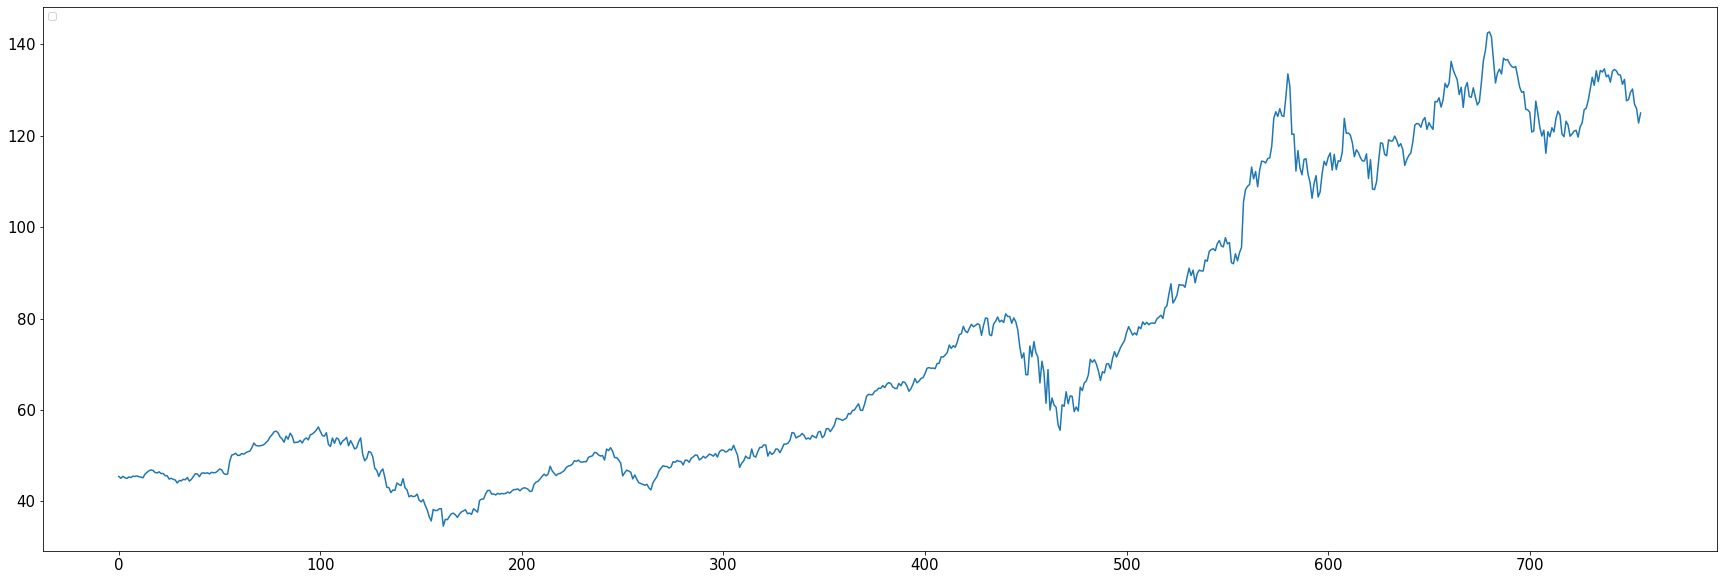

In [7]:
#Initial Visualization

fig = plt.figure(figsize=(30,10))
ax = plt.axes()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.plot(df.index, df['AdjClose'])
plt.legend(loc='upper left')

In [8]:
def series_filter(values, kernel_size=3):
    """
    Filter a time series. Practically, calculated mean value inside kernel size.
    As math formula, see https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html.
    :param values:
    :param kernel_size:
    :return: The list of filtered average
    """
    filter_values = np.cumsum(values, dtype=float)

    filter_values[kernel_size:] = filter_values[kernel_size:] - filter_values[:-kernel_size]
    filter_values[kernel_size:] = filter_values[kernel_size:] / kernel_size

    for i in range(1, kernel_size):
        filter_values[i] /= i + 1

    return filter_values


def extrapolate_next(values):
    """
    Extrapolates the next value by sum up the slope of the last value with previous values.
    :param values: a list or numpy array of time-series
    :return: the next value of time-series
    """

    last_value = values[-1]
    slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
    slope[0] = 0
    next_values = last_value + np.cumsum(slope)

    return next_values


def merge_series(values, extend_num=5, forward=5):

    next_value = extrapolate_next(values)[forward]
    extension = [next_value] * extend_num

    if isinstance(values, list):
        merge_values = values + extension
    else:
        merge_values = np.append(values, extension)
    return merge_values

In [9]:
class Silency(object):
    def __init__(self, amp_window_size, series_window_size, score_window_size):
        self.amp_window_size = amp_window_size
        self.series_window_size = series_window_size
        self.score_window_size = score_window_size

    def transform_silency_map(self, values):
        """
        Transform a time-series into spectral residual, which is method in computer vision.
        For example, See https://github.com/uoip/SpectralResidualSaliency.
        :param values: a list or numpy array of float values.
        :return: silency map and spectral residual
        """

        freq = np.fft.fft(values)
        mag = np.sqrt(freq.real ** 2 + freq.imag ** 2)
        spectral_residual = np.exp(np.log(mag) - series_filter(np.log(mag), self.amp_window_size))

        freq.real = freq.real * spectral_residual / mag
        freq.imag = freq.imag * spectral_residual / mag

        silency_map = np.fft.ifft(freq)
        return silency_map

    def transform_spectral_residual(self, values):
        silency_map = self.transform_silency_map(values)
        spectral_residual = np.sqrt(silency_map.real ** 2 + silency_map.imag ** 2)
        return spectral_residual

    def generate_anomaly_score(self, values, type="avg"):
        """
        Generate anomaly score by spectral residual.
        :param values:
        :param type:
        :return:
        """

        extended_series = merge_series(values, self.series_window_size, self.series_window_size)
        mag = self.transform_spectral_residual(extended_series)[: len(values)]

        if type == "avg":
            ave_filter = series_filter(mag, self.score_window_size)
            score = (mag - ave_filter) / ave_filter
        elif type == "abs":
            ave_filter = series_filter(mag, self.score_window_size)
            score = np.abs(mag - ave_filter) / ave_filter
        elif type == "chisq":
            score = stats.chi2.cdf((mag - np.mean(mag)) ** 2 / np.var(mag), df=1)
        else:
            raise ValueError("No type!")
        return score

In [10]:
# Less than period
amp_window_size = 10

# (maybe) same as period
series_window_size=10

# a number enough larger then period
score_window_size=25

In [11]:
spec = Silency(amp_window_size, series_window_size, score_window_size)

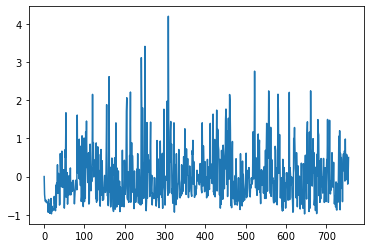

In [12]:
data = np.array(df['AdjClose'])
score = spec.generate_anomaly_score(data)
plt.plot(score)

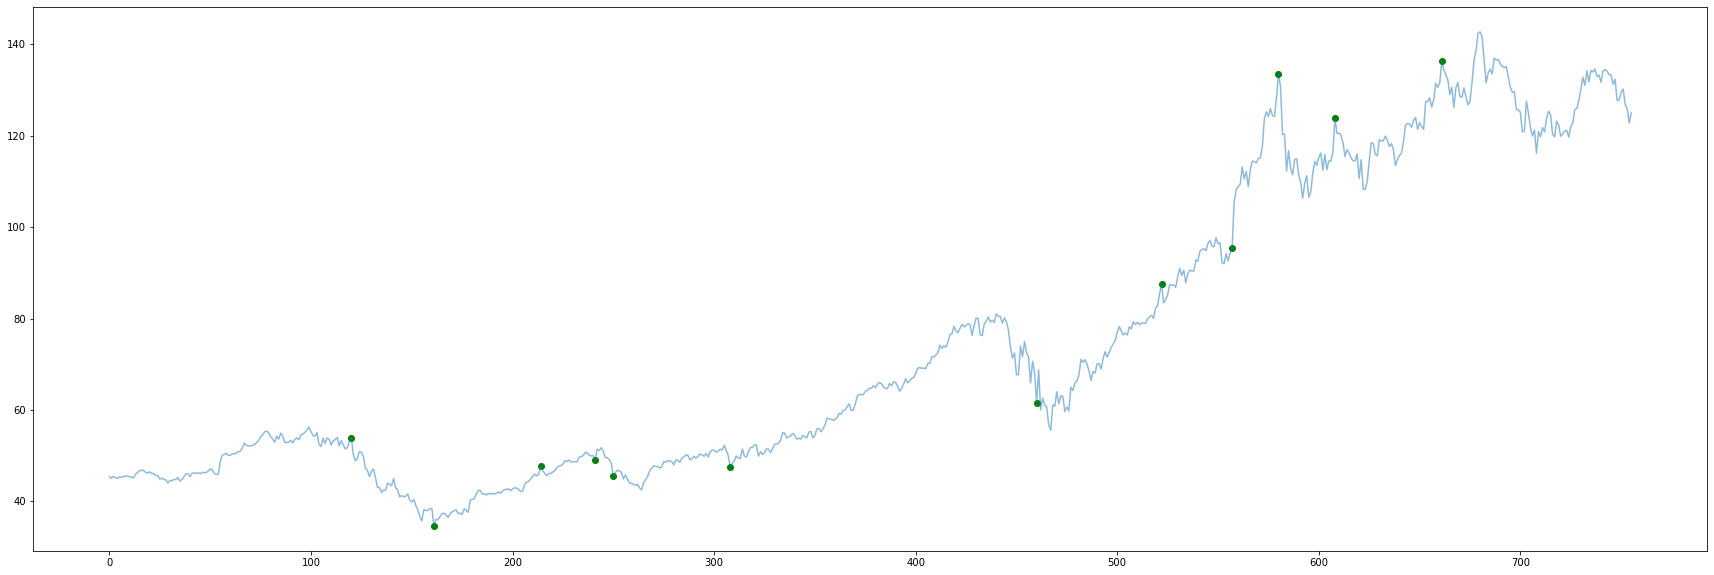

In [16]:
# plot data with estimated anomalous points
fig = plt.figure(figsize=(30,10))
plt.plot(data, alpha=0.5, label="observation")
index_changes = np.where(score > np.percentile(score, 98.5))[0]
plt.scatter(index_changes, data[index_changes], c='green', label="change point")

In [15]:
index_changes

array([120, 161, 214, 241, 250, 308, 460, 522, 557, 580, 608, 661],
      dtype=int64)